In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#vamos a hacer la descomposicion dinamica

import h5py
import rotation as rot
import numpy as np

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector = ('00','01','03','09','13','14','18','19','20','21')

snapshot=range(497,496,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    #a = snap['subhalo_000/Time'].value
    #z = (a0/a)-1
    #t = conv(z, h, omega_lambda, omega_matter)

    for i in range(2,3):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s' %vector[i])+ '/Drk/Masses'].value
        
        z = a0/aexp - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp/h
        ystr = (pstr[:,1]-cm[1])*aexp/h
        zstr = (pstr[:,2]-cm[2])*aexp/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp/h
        ygas = (pgas[:,1]-cm[1])*aexp/h
        zgas = (pgas[:,2]-cm[2])*aexp/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp/h
        ydrk = (pdrk[:,1]-cm[1])*aexp/h
        zdrk = (pdrk[:,2]-cm[2])*aexp/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        masa_str = masa_str/h
        masa_gas = masa_gas/h
        masa_drk = masa_drk/h
        
        r200 = r200*aexp/h
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        limit_str = np.where(r<r200)
        limit_gas = np.where(rgas<r200)
        limit_drk = np.where(rdrk<r200)
        
#-----------------para las veloc----------------------------------------------------
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
                
        Mc = np.cumsum((masa_str[limit])[r_indice])
        Mgal = Mc[-1]
               
        razon = Mc/Mgal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#------------------------------------------------------------------        
#----------componentes de la velocidad del centro de masa------------

        veloc,=np.where(r<r50[-1])
    
        vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm

        if isnap == 497: 
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])
            
            
# ------ posiciones y veloc rotadas de las estrellas -------------------------------------
        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        xn = xn[limit]
        yn = yn[limit]
        zn = zn[limit]
        v_x = vxn[limit]
        v_y = vyn[limit]
        v_z = vzn[limit]

# --------para la E potencial-----------------------------------------------
        x0 = xstr[limit]
        y0 = ystr[limit]
        z0 = zstr[limit]
    
        x_str = xstr[limit_str]
        y_str = ystr[limit_str]
        z_str = zstr[limit_str]
        
        x_gas = xgas[limit_gas]
        y_gas = ygas[limit_gas]
        z_gas = zgas[limit_gas]
        
        x_drk = xdrk[limit_drk]
        y_drk = ydrk[limit_drk]
        z_drk = zdrk[limit_drk]
    
        m0 = masa_str[limit]
        masa_str = masa_str[limit_str]
        masa_gas = masa_gas[limit_gas]
        masa_drk = masa_drk[limit_drk]

        num = len(x0)
        num_str = len(x_str)
        num_gas = len (x_gas)
        num_drk = len (x_drk)

#------Energía Cinética-------------------------------
        K = 1./2*(v_x**2+v_y**2+v_z**2)

        print num, num_str

263629 290127


In [3]:
#calculamos la energia potencial

from energia_potencial import *

u_str = energia_potencial.ep_part(m0, masa_str, x0,y0,z0, x_str,y_str,z_str, num, num_str)
u_gas = energia_potencial.ep_part(m0, masa_gas, x0,y0,z0, x_gas,y_gas,z_gas, num, num_gas)
u_drk = energia_potencial.ep_part(m0, masa_drk, x0,y0,z0, x_drk,y_drk,z_drk, num, num_drk)

d = np.ndarray([np.size(u_str),3])
d[:,0] = u_str
d[:,1] = u_gas
d[:,2] = u_drk
np.savetxt('energia_potencial3.dat', d, '%12.6f', '\t')

In [3]:
#-----------Energia total-------------------------------------
cm=np.loadtxt('/home/ornela/python/energia_potencial3.dat')
u_str = cm[:,0]
u_gas = cm[:,1]
u_drk = cm[:,2]

U = u_str + u_gas + u_drk
U = U/(m0*1e10)
e = K - U
#print len(e)
#print K
#print U

#------Momento angular---------------

Jz = xn*v_y - yn*v_x

print len(Jz)

263629


In [4]:
import jc
jcir = jc.jcirc(e, Jz)

d2 = np.ndarray([np.size(e),3])
d2[:,0] = e
d2[:,1] = Jz
d2[:,2] = jcir
np.savetxt('energ_jz_sh03.dat', d2, '%12.6f', '\t')

Determining the local particle density...
-------------------------------------------------


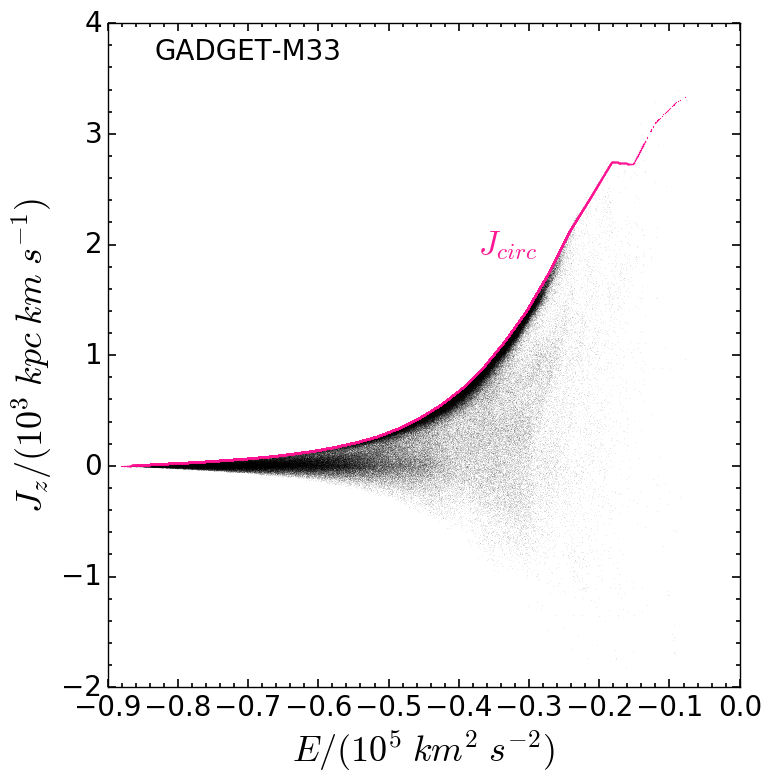

In [5]:
#Graficamos energia para galaxia 03
cm2=np.loadtxt('/home/ornela/python/energ_jz_sh03.dat')
e = cm2[:,0]
jz = cm2 [:,1]
jcir = cm2 [:,2]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(e/1e5,jz/1e3,'.', markersize=0.05, color = 'k')
ax.plot(e/1e5,jcir/1e3,'.', markersize=0.8, color = 'deeppink')
#ax.set_ylim(-1000,1000)
#ax.set_xlim(-1.8,0)
#ax.set_title('Gadget - M33', fontsize=22)
ax.set_xlabel(u'$E/(10^{5}\;km^{2}\;s^{-2})$', fontsize=26)
ax.set_ylabel(u'$J_{z}/(10^{3}\;kpc\;km\;s^{-1})$', fontsize=26)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')
#plt.text(-0.8, 2600, 'M33', fontsize=20, color='k', ha='center', va='center') 
plt.text(-0.7, 3.75, 'GADGET-M33', fontsize=20, color='k', ha='center', va='center')
plt.text(-0.33, 2, u'$J_{circ}$', fontsize=24, color='deeppink', ha='center', va='center')

#fig.savefig('/home/ornela/Escritorio/seminario2/imagenes/M33_EvsJz.png', dpi = 100)
fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_M33_EvsJz.png', dpi = 100)
plt.show()

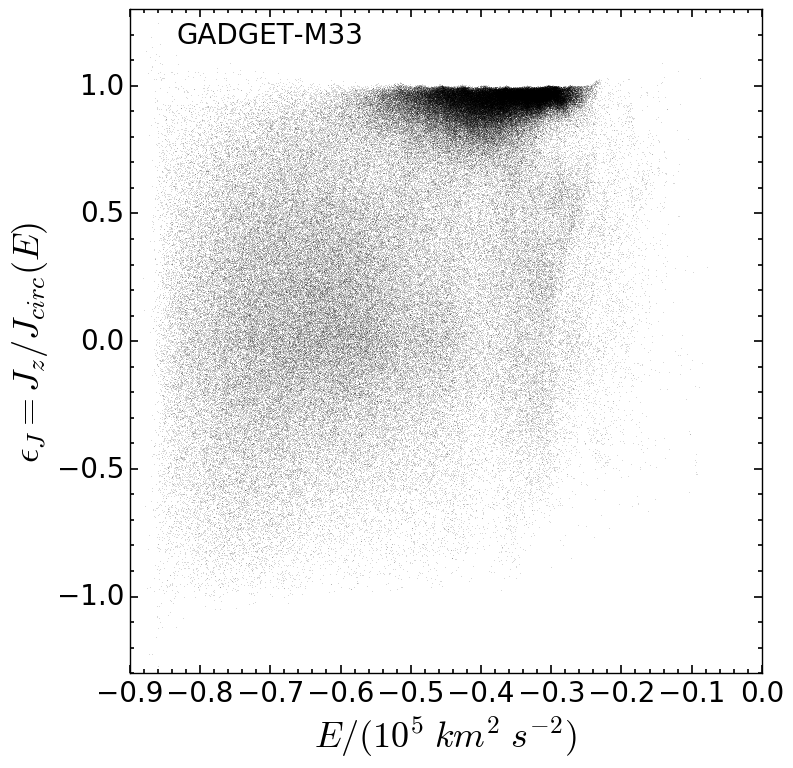

In [3]:
#circularidad para la galaxia 03
import matplotlib.patches as patches
cm2=np.loadtxt('/home/ornela/python/energ_jz_sh03.dat')
e = cm2[:,0]
jz = cm2[:,1]
jcir = cm2[:,2]

circ = jz/jcir

e = e/1e5

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(e,circ,'.', markersize=0.1, color = 'k')
#ax.plot(e/1e5,jcir,'.', markersize=0.1, color = 'magenta')
ax.set_ylim(-1.3,1.3)
#ax.set_xlim(-0.7,0)
#ax.set_title('Gadget-M33', fontsize=22)
ax.set_xlabel(u'$E/(10^{5}\;km^{2}\;s^{-2})$', fontsize=26)
ax.set_ylabel(u'$\epsilon_{J}=J_{z}/J_{circ}(E)$', fontsize=26)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')
plt.text(-0.7, 1.2, 'GADGET-M33', fontsize=20, color='k', ha='center', va='center')
fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_M33_EvsCirc.png', dpi = 100)

'''ax.add_patch( patches.Rectangle( 
        (-0.85, 0.8), #(x,y)
        0.5, #ancho
        0.2, #alto
        fill=False, # remove background
        edgecolor='blue', linewidth=2))
ax.add_patch( patches.Rectangle( (-1.55, -0.3), 0.7, 1.1, fill=False, edgecolor='red', linewidth=2))
ax.add_patch( patches.Rectangle( (-0.8, -0.5), 0.5, 1.3, fill=False, edgecolor='green', linewidth=2))'''
#fig.savefig('/home/ornela/Escritorio/seminario2/imagenes/M33_EvsCirc.png', dpi = 100)
plt.show()

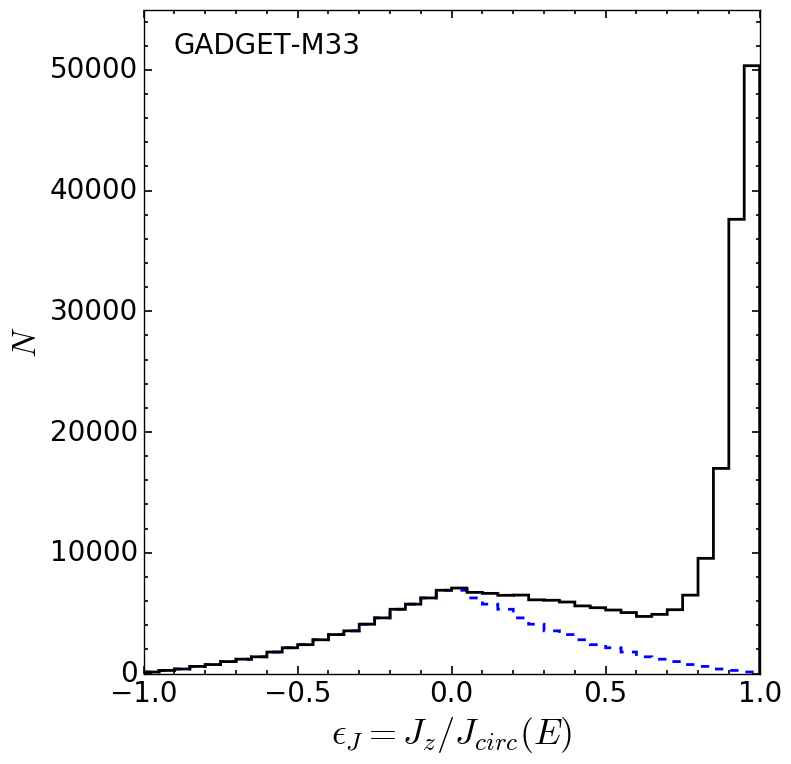

In [4]:
fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.18, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
bins = frange(-1,1,0.05)
bins2 = frange(0,1,0.05)
mask, = np.where(circ<0)
#circ2 = -circ[mask]
circ2 = np.append(-circ[mask],circ[mask])

plt.hist(circ2,bins, histtype='step',color='blue',linestyle='--', lw=2)
plt.hist(circ,bins, histtype='step',color='k', lw=2)
#ax.set_title('Gadget - M33', fontsize=22)
ax.set_ylim(0,55000)
ax.set_ylabel(u'$N$', fontsize=24)
ax.set_xlabel(u'$\epsilon_{J}=J_{z}/J_{circ}(E)$', fontsize=26)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')
plt.text(-0.6, 52000, 'GADGET-M33', fontsize=20, color='k', ha='center', va='center')
fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_M33_hcirc.png', dpi = 100)
#fig.savefig('/home/ornela/Escritorio/seminario2/imagenes/M33_hist_circ.png', dpi = 100)

'''ax=fig.add_subplot(212)
bins = frange(-1.8,0,0.05)
plt.hist(e,bins, histtype='step',color='k')
ax.set_ylabel(u'$N$', fontsize=24)
ax.set_xlabel(u'$E/(10^{5}\;km^{2}\;s^{-2})$', fontsize=24)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')'''

plt.show()

In [24]:
'''#galaxia 00
ii = []
jj = []
kk = []
for i in range(0,num-1):
    if circ[i] < 1 and circ[i] >0.8 and e[i] < -0.35 and e[i] > -0.85:
        ii.append(i)
    if circ[i] < 0.8 and circ[i] >-0.3 and e[i] < -0.85 and e[i] > -1.55:
        jj.append(i)
    if circ[i] < 0.8 and circ[i] >-0.5 and e[i] < -0.3 and e[i] > -0.8:
        kk.append(i)'''

In [25]:
'''#galaxia 00
x1=[]
y1=[]
z1=[]
x2=[]
y2=[]
z2=[]
x3=[]
y3=[]
z3=[]
for ind1 in ii:
    x1.append(xn[ind1])
    y1.append(yn[ind1])
    z1.append(zn[ind1])
for ind2 in jj:
    x2.append(xn[ind2])
    y2.append(yn[ind2])
    z2.append(zn[ind2])
for ind3 in kk:
    x3.append(xn[ind3])
    y3.append(yn[ind3])
    z3.append(zn[ind3])'''

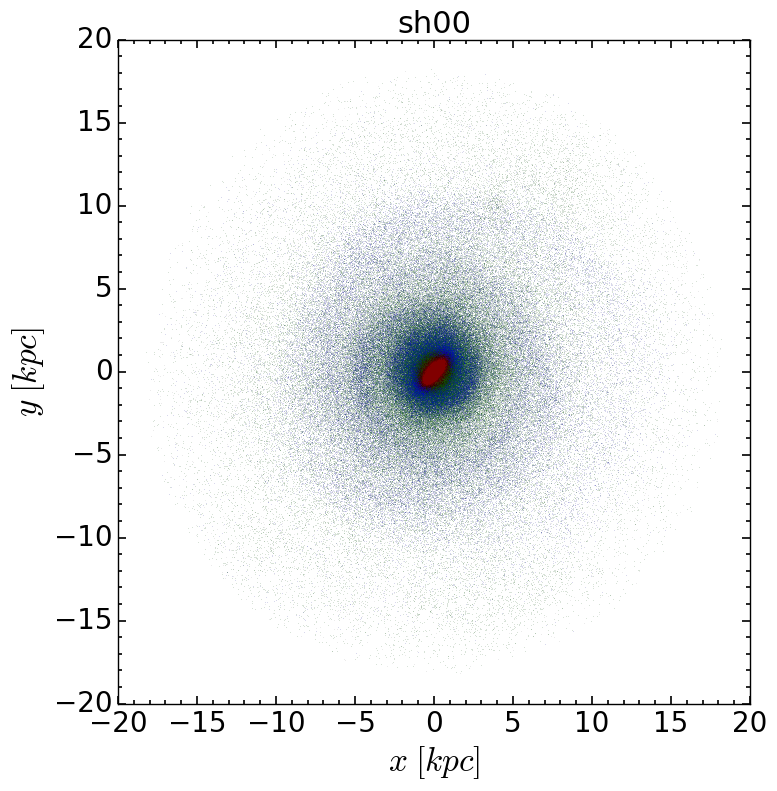

In [27]:
'''#galaxia 00
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.set_title('sh00', fontsize=22)
ax.set_xlabel(u'$x\;[kpc]$', fontsize=24)
ax.set_ylabel(u'$y\;[kpc]$', fontsize=24)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')
ax.plot(xn,yn,'.', markersize=0.05, color = 'k')
ax.plot(x3,y3,'.', markersize=0.05, color = 'green')
ax.plot(x1,y1,'.', markersize=0.05, color = 'blue')
ax.plot(x2,y2,'.', markersize=0.005, color = 'red')
fig.savefig('/home/ornela/python/Graficos3/sh00_part-xy.png', dpi = 100)
plt.show()'''

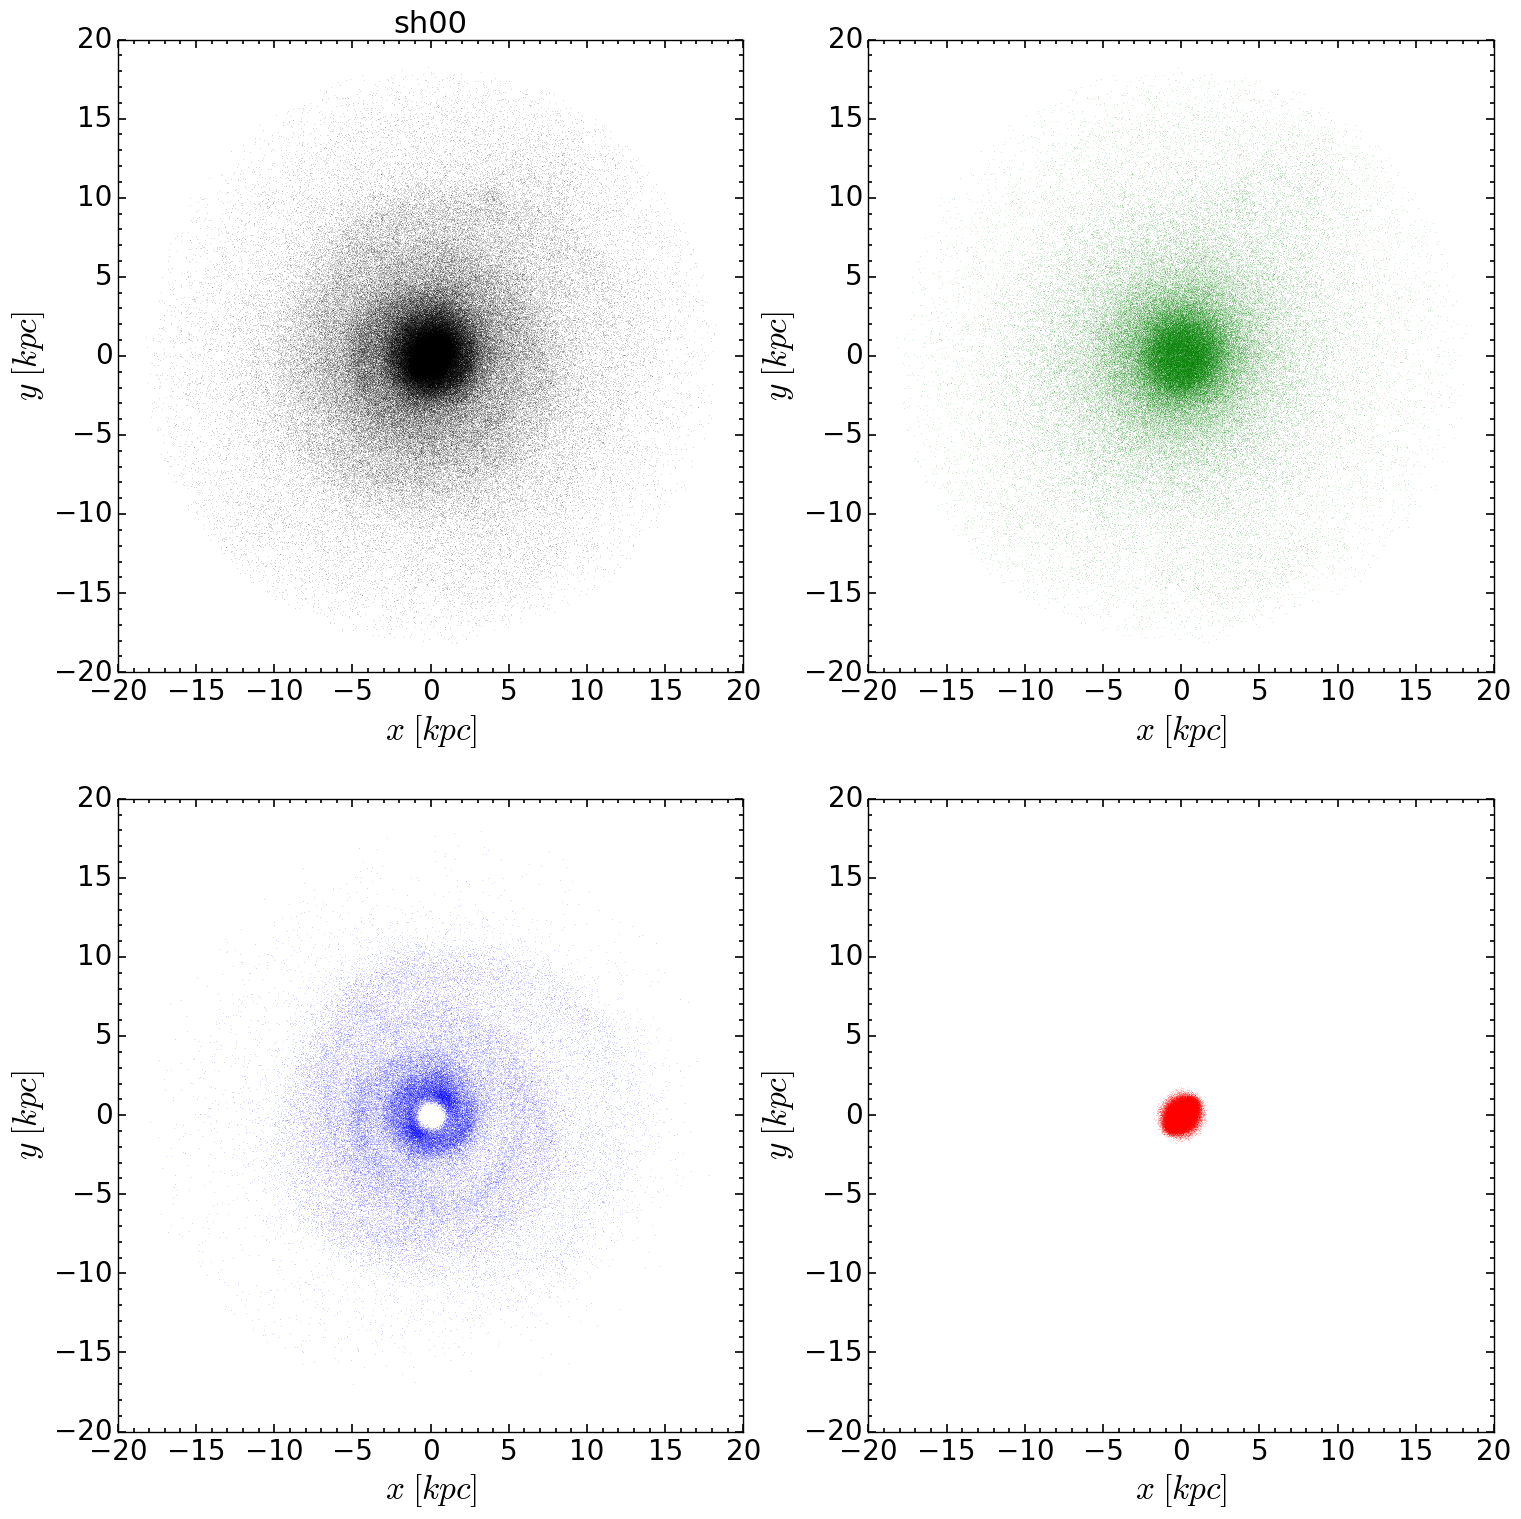

In [29]:
'''#galaxia 00 particulas, componentes separadas
fig=plt.figure(1,figsize=(16,16))
fig.subplots_adjust(bottom=0.08, left =0.09, right = 0.95, top = 0.95, wspace=0.2, hspace= 0.2)
        
ax1=fig.add_subplot(221)
ax1.set_title('sh00', fontsize=22)
ax1.set_xlabel(u'$x\;[kpc]$', fontsize=24)
ax1.set_ylabel(u'$y\;[kpc]$', fontsize=24)
ax1.minorticks_on()
ax1.set_xlim(-20,20)
ax1.set_ylim(-20,20)
ax1.tick_params( labelsize=20)
ax1.tick_params('both', length=3, width=1.2,which='minor')
ax1.tick_params('both', length=6, width=1.2,which='major')
ax1.plot(xn,yn,'.', markersize=0.1, color = 'k')

ax2=fig.add_subplot(222)
ax2.set_xlabel(u'$x\;[kpc]$', fontsize=24)
ax2.set_ylabel(u'$y\;[kpc]$', fontsize=24)
ax2.minorticks_on()
ax2.set_xlim(-20,20)
ax2.set_ylim(-20,20)
ax2.tick_params( labelsize=20)
ax2.tick_params('both', length=3, width=1.2,which='minor')
ax2.tick_params('both', length=6, width=1.2,which='major')
ax2.plot(x3,y3,'.', markersize=0.1, color = 'green')

ax3=fig.add_subplot(223)
ax3.set_xlabel(u'$x\;[kpc]$', fontsize=24)
ax3.set_ylabel(u'$y\;[kpc]$', fontsize=24)
ax3.minorticks_on()
ax3.set_xlim(-20,20)
ax3.set_ylim(-20,20)
ax3.tick_params( labelsize=20)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')
ax3.plot(x1,y1,'.', markersize=0.1, color = 'blue')

ax4=fig.add_subplot(224)
ax4.set_xlabel(u'$x\;[kpc]$', fontsize=24)
ax4.set_ylabel(u'$y\;[kpc]$', fontsize=24)
ax4.minorticks_on()
ax4.set_xlim(-20,20)
ax4.set_ylim(-20,20)
ax4.tick_params( labelsize=20)
ax4.tick_params('both', length=3, width=1.2,which='minor')
ax4.tick_params('both', length=6, width=1.2,which='major')
ax4.plot(x2,y2,'.', markersize=0.1, color = 'red')

fig.savefig('/home/ornela/python/Graficos3/sh00_part.png', dpi = 100)
plt.show()'''

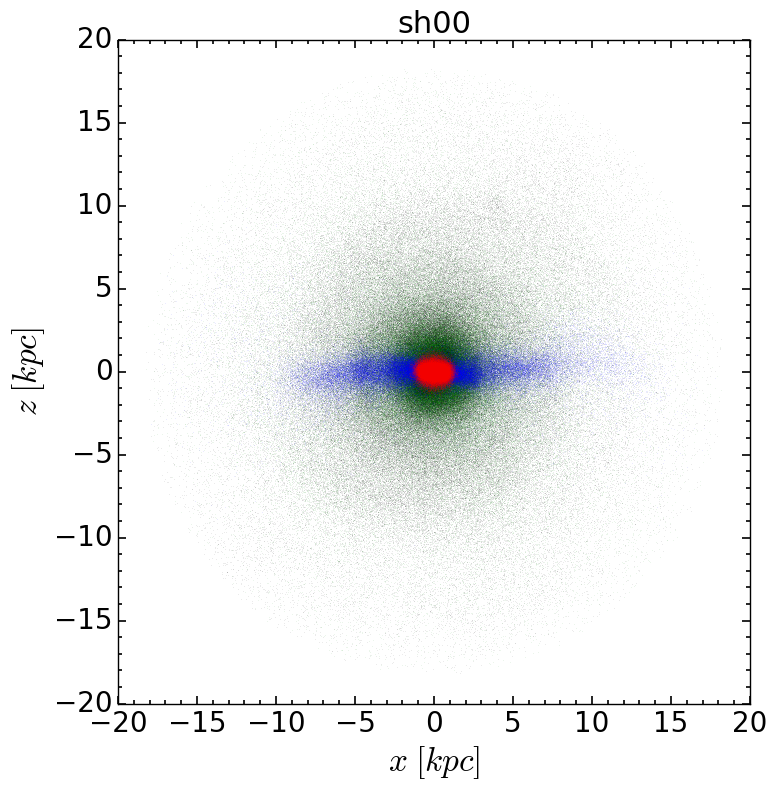

In [37]:
'''#galaxia 00
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.set_title('sh00', fontsize=22)
ax.set_xlabel(u'$x\;[kpc]$', fontsize=24)
ax.set_ylabel(u'$z\;[kpc]$', fontsize=24)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')
ax.plot(xn,yn,'.', markersize=0.05, color = 'k')
ax.plot(x3,z3,'.', markersize=0.05, color = 'green')
ax.plot(x1,z1,'.', markersize=0.05, color = 'blue')
ax.plot(x2,z2,'.', markersize=0.05, color = 'red')
fig.savefig('/home/ornela/python/Graficos3/sh00_part-xz.png', dpi = 100)
plt.show()'''

In [38]:
'''#galaxia 00
pp = []
for i in range(0,num-1):
    if zn[i]<0.5 and zn[i]>-0.5 and xn[i]<-yn[i]+2 and xn[i]>-yn[i]-2 and yn[i]<xn[i]+0.5 and yn[i]>xn[i]-0.5 :
        pp.append(i)
'''

In [39]:
'''#galaxia 00
energia=[]
circularidad=[]

for indice in pp:
    energia.append(e[indice])
    circularidad.append(circ[indice])'''

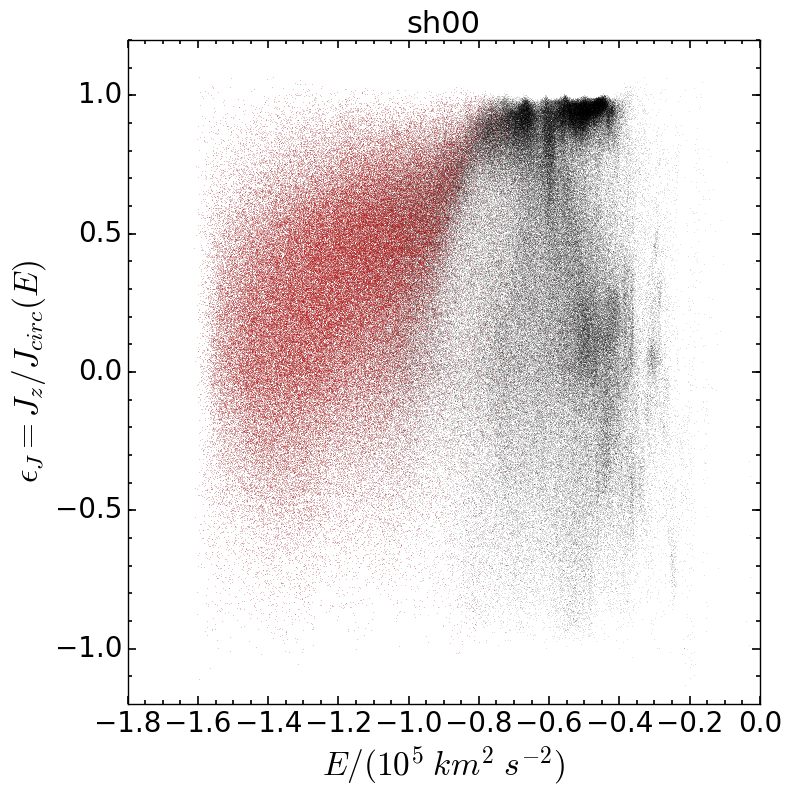

In [41]:
'''#galaxia 00
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.set_title('sh00', fontsize=22)
ax.set_xlabel(u'$E/(10^{5}\;km^{2}\;s^{-2})$', fontsize=24)
ax.set_ylabel(u'$\epsilon_{J}=J_{z}/J_{circ}(E)$', fontsize=24)
ax.minorticks_on()
ax.set_ylim(-1.2,1.2)
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')
ax.plot(e,circ,'.', markersize=0.08, color = 'k')
ax.plot(energia,circularidad,'.', markersize=0.08, color = 'red')
fig.savefig('/home/ornela/python/Graficos3/sh00_Evscirc_color.png', dpi = 100)
plt.show()'''

In [42]:
'''#galaxia 00
xxx=[]
yyy=[]
zzz=[]
for indice in pp:
    xxx.append(xn[indice])
    yyy.append(yn[indice])
    zzz.append(zn[indice])'''

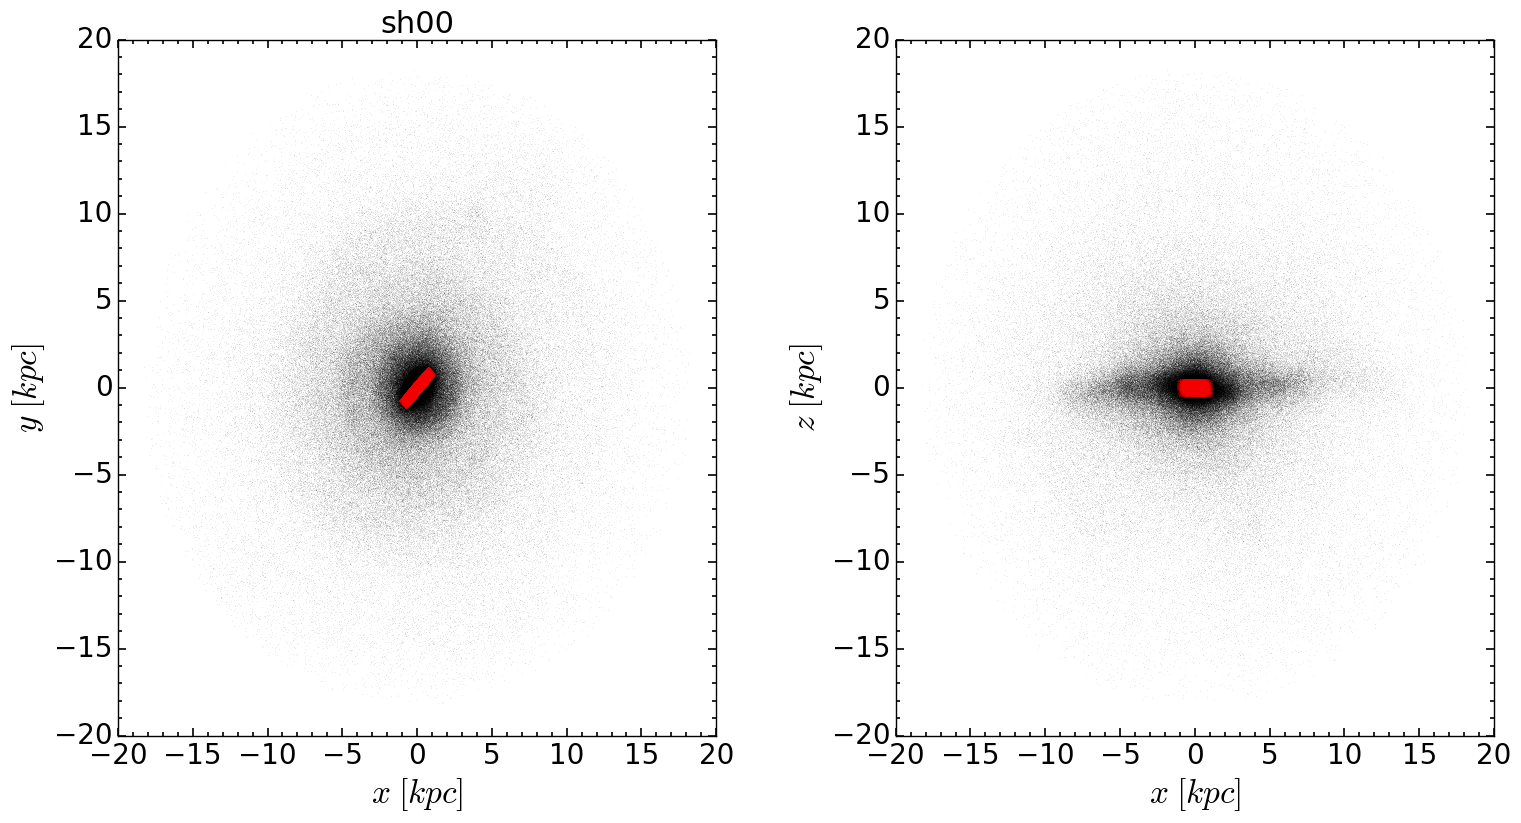

In [43]:
'''#galaxia 00 
fig=plt.figure(1,figsize=(16,8))
fig.subplots_adjust(bottom=0.08, left =0.09, right = 0.95, top = 0.95, wspace=0.3, hspace= 0.05)
ax=fig.add_subplot(121)
ax.set_title('sh00', fontsize=22)
ax.set_xlabel(u'$x\;[kpc]$', fontsize=24)
ax.set_ylabel(u'$y\;[kpc]$', fontsize=24)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')
ax.plot(xn,yn,'.', markersize=0.05, color = 'k')
ax.plot(xxx,yyy,'.', markersize=0.05, color = 'red')

ax=fig.add_subplot(122)
#ax.set_title('subhalo_00', fontsize=24)
ax.set_xlabel(u'$x\;[kpc]$', fontsize=24)
ax.set_ylabel(u'$z\;[kpc]$', fontsize=24)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')
ax.plot(xn,zn,'.', markersize=0.05, color = 'k')
ax.plot(xxx,zzz,'.', markersize=0.05, color = 'red')
fig.savefig('/home/ornela/python/Graficos3/sh00_part_color.png', dpi = 100)
plt.show()'''

In [7]:
import numpy as np

def conv(z, h, omega_lambda, omega_matter):

    H0=100*h
#conversion Mpc --> km
    conv1=1./(1e6*206265*1.496e8)
#conversion de s --> Gyr
    conv2=3600*24*365.25*1e9
    H0=H0*conv1*conv2

    c1=np.sqrt(omega_lambda*(1.+z)**(-3.))+np.sqrt((omega_lambda*(1.+z)**(-3.))+omega_matter)
    ln=np.log(c1/np.sqrt(omega_matter))
    c2=2./(3.*np.sqrt(omega_lambda))
        
    time = (1./H0)*c2*ln

    return time

253005
253005


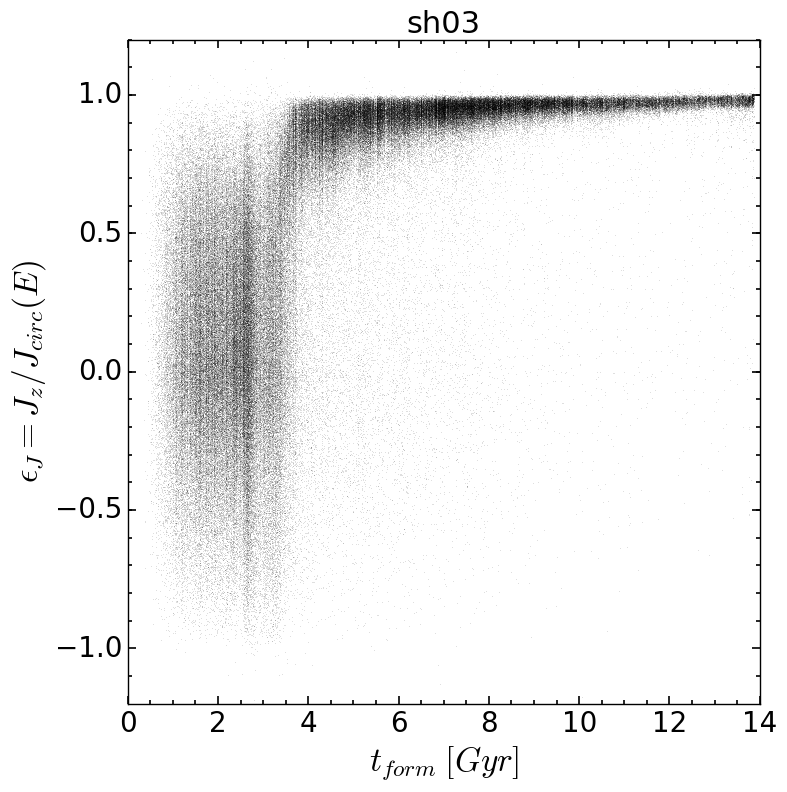

In [9]:
#tiempo de form vs circularidad

h=0.732
G = 4.299e-6
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)

cm2=np.loadtxt('/home/ornela/python/energ_jz_sh03.dat')
e = cm2[:,0]
jz = cm2[:,1]
jcir = cm2[:,2]

circ = jz/jcir

print len(circ)

ftime = snap['subhalo_003/Str/FormationTime'].value

print len(ftime[limit])
ftime = ftime[limit]

z = (a0/ftime)-1
tform = conv(z, h, omega_lambda, omega_matter)

'''#galaxia 00
tform_=[]
circularidad=[]

for indice in pp:
    tform_.append(tform[indice])
    circularidad.append(circ[indice])'''

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
ax.plot(tform,circ,'.', markersize=0.08, color = 'k')
#ax.plot(tform_,circularidad,'.', markersize=0.08, color = 'red')
ax.set_title('sh03', fontsize=22)
ax.set_xlabel(u'$t_{form}\;[Gyr]$', fontsize=24)
ax.set_ylabel(u'$\epsilon_{J}=J_{z}/J_{circ}(E)$', fontsize=24)
ax.minorticks_on()
ax.set_ylim(-1.2,1.2)
ax.tick_params( labelsize=20)
ax.tick_params('both', length=3, width=1.2,which='minor')
ax.tick_params('both', length=6, width=1.2,which='major')

#fig.savefig('/home/ornela/python/Graficos3/sh00_Evscirc_color.png', dpi = 100)
plt.show()
